# Arbor-Neuron validation output analysis

In [1]:
import re
import json
import pandas
import matplotlib.pyplot as plt
from IPython.display import display

Tests with OK status:

In [2]:
%%bash

rm tests_{ok,error,na} || true
grep test_l5pc\ OK l5pc_validate_neuron_arbor_* | tee tests_ok

l5pc_validate_neuron_arbor_all.ipynb:      "Default dt (0.025): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.000449 (0.05), 2.05e-08 (0.0005).\n"
l5pc_validate_neuron_arbor_all.ipynb:      "Fine dt (0.001): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.000377 (0.05), 4.71e-08 (0.0005).\n"
l5pc_validate_neuron_arbor_apical_Ih_Im.ipynb:      "Default dt (0.025): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.000976 (0.05), 6.83e-08 (0.0005).\n"
l5pc_validate_neuron_arbor_apical_Ih_Im.ipynb:      "Fine dt (0.001): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.000625 (0.05), 7.06e-07 (0.0005).\n"
l5pc_validate_neuron_arbor_apical_Ih_Im_NaTs2_t.ipynb:      "Default dt (0.025): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.00202 (0.05), 1.55e-06 (0.0005).\n"
l5pc_va

Tests with ERROR status:

In [3]:
%%bash

grep test_l5pc\ ERROR l5pc_validate_neuron_arbor_* | tee tests_error

l5pc_validate_neuron_arbor_axonal_CaDynamics_E2_Nap_Et2.ipynb:      "Fine dt (0.001): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.000127 (0.05), 0.000575 (0.0005).\n"
l5pc_validate_neuron_arbor_axonal_CaDynamics_E2_SKv3_1_Nap_Et2.ipynb:      "Default dt (0.025): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.000474 (0.05), 0.00344 (0.0005).\n"
l5pc_validate_neuron_arbor_axonal_CaDynamics_E2_SKv3_1_Nap_Et2.ipynb:      "Fine dt (0.001): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.000466 (0.05), 0.00103 (0.0005).\n"
l5pc_validate_neuron_arbor_axonal_CaDynamics_E2_SKv3_1_NaTa_t.ipynb:      "Default dt (0.025): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.086 (0.05), 2.39e-05 (0.0005).\n"
l5pc_validate_neuron_arbor_axonal_Ca_HVA_SKv3_1_Nap_Et2.ipynb:      "Default dt (0.025): test_l5pc ERROR! T

Tests with N/A result:

In [4]:
%%bash

touch tests_na
for f in $(ls l5pc_validate_neuron_arbor_*); do 
    if ! grep test_l5pc\ OK $f > /dev/null && ! grep test_l5pc\ ERROR $f > /dev/null; then 
        echo "$f" | tee -a tests_na
    fi
done

l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2_K_Tst.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2_NaTa_t.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2_SK_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_CaDynamics_E2_NaTa_t.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_Ca_HVA_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA_Ca_LVAst.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA_Ih.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_LVAst_Ih.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_LVAst.ipynb
l5pc_validate_neuron_arbor_somatic_NaTs2_t_CaDynamics_E2_Ca_HVA.ipynb
l5pc_validate_neuron_arbor_somatic_NaTs2_t_CaDynamics_E2_Ca_LVAst.ipynb


In [5]:
# Read output
with open('tests_ok') as f:
    tests_ok = f.readlines()

with open('tests_error') as f:
    tests_error = f.readlines()

with open('tests_na') as f:
    tests_na = f.readlines()

Display test results. Test status can be ERROR due to relative L1-norm exceeding the tolerance or, similarly, the quadrature error exceeding a lower threshold. 

In [6]:
def parse_test_status_line(line):
    numeric_vars = ['dt', 'l1_norm', 'l1_tol', 'l1_error', 'l1_error_tol']
    numbers = [r'(?P<{}>[+\-]?\d+[\.]?\d*[eE]?[+\-]?\d*)'.format(name) 
               for name in numeric_vars]
    test_status_pattern = r'^(?P<filename>l5pc_validate_neuron_arbor_\w+.ipynb):\s+\"(?P<dt_setting>Default|Fine) dt \({}\): test_l5pc (?P<test_result>OK|ERROR)! [\w\s-]+\(tol in brackets\) are {} \({}\), {} \({}\)'.format(*numbers)
    match = re.search(test_status_pattern, line)
    groupdict = match.groupdict()
    for v in numeric_vars:
        groupdict[v] = float(groupdict[v])
    return groupdict


# extract params from executed notebooks
def extract_mechs_params(filename):
    with open(filename) as f:
        nb = json.load(f)
    # print(nb['cells'][2]['source'])
    exec('global mechanism_defs\nglobal extra_params\n' + ''.join(nb['cells'][2]['source']))
    return mechanism_defs, extra_params


test_results = []
for line in tests_ok + tests_error:
    result = parse_test_status_line(line)
    region_mechs = result['filename'][len('l5pc_validate_neuron_arbor_'):-len('.ipynb')].split('_')
    result['region'] = region_mechs[0]
    result['mechs_str'] = '_'.join(region_mechs[1:])
    
    mechs, params = extract_mechs_params(result['filename'])    
    result['mechs'] = mechs
    result['extra_params'] = extra_params
    test_results.append(result)

test_status_df = pandas.DataFrame(test_results)
regional_test_status = dict()

max_rows_default = pandas.options.display.max_rows
pandas.options.display.max_rows = None  # uncomment for full view
for region, regional_test_status_df in test_status_df.groupby('region'):
    regional_test_status[region] = regional_test_status_df.sort_values(by='l1_norm', ascending=False)
    display(regional_test_status[region])
pandas.options.display.max_rows = max_rows_default

,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
0,l5pc_validate_neuron_arbor_all.ipynb,Default,0.025,OK,0.000449,0.05,2.050000e-08,0.0005,all,,{'all': ['pas']},"{'v_init': 'global', 'celsius': 'global', 'g_p..."
1,l5pc_validate_neuron_arbor_all.ipynb,Fine,0.001,OK,0.000377,0.05,4.710000e-08,0.0005,all,,{'all': ['pas']},"{'v_init': 'global', 'celsius': 'global', 'g_p..."


,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
14,l5pc_validate_neuron_arbor_apical_Ih_SKv3_1_Na...,Default,0.025,OK,0.003790,0.05,8.210000e-07,0.0005,apical,Ih_SKv3_1_NaTs2_t,"{'all': ['pas'], 'apical': ['Ih', 'SKv3_1', 'N...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
22,l5pc_validate_neuron_arbor_apical_Im_SKv3_1_Na...,Default,0.025,OK,0.003700,0.05,4.810000e-07,0.0005,apical,Im_SKv3_1_NaTs2_t,"{'all': ['pas'], 'apical': ['Im', 'SKv3_1', 'N...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
30,l5pc_validate_neuron_arbor_apical_SKv3_1_NaTs2...,Default,0.025,OK,0.003670,0.05,2.030000e-06,0.0005,apical,SKv3_1_NaTs2_t,"{'all': ['pas'], 'apical': ['SKv3_1', 'NaTs2_t']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
24,l5pc_validate_neuron_arbor_apical.ipynb,Default,0.025,OK,0.003650,0.05,3.630000e-07,0.0005,apical,,"{'all': ['pas'], 'apical': ['Ih', 'Im', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
15,l5pc_validate_neuron_arbor_apical_Ih_SKv3_1_Na...,Fine,0.001,OK,0.002420,0.05,2.160000e-06,0.0005,apical,Ih_SKv3_1_NaTs2_t,"{'all': ['pas'], 'apical': ['Ih', 'SKv3_1', 'N...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
31,l5pc_validate_neuron_arbor_apical_SKv3_1_NaTs2...,Fine,0.001,OK,0.002340,0.05,7.900000e-06,0.0005,apical,SKv3_1_NaTs2_t,"{'all': ['pas'], 'apical': ['SKv3_1', 'NaTs2_t']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
12,l5pc_validate_neuron_arbor_apical_Ih_SKv3_1.ipynb,Default,0.025,OK,0.002140,0.05,1.640000e-06,0.0005,apical,Ih_SKv3_1,"{'all': ['pas'], 'apical': ['Ih', 'SKv3_1']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
25,l5pc_validate_neuron_arbor_apical.ipynb,Fine,0.001,OK,0.002090,0.05,9.780000e-06,0.0005,apical,,"{'all': ['pas'], 'apical': ['Ih', 'Im', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
23,l5pc_validate_neuron_arbor_apical_Im_SKv3_1_Na...,Fine,0.001,OK,0.002090,0.05,2.040000e-06,0.0005,apical,Im_SKv3_1_NaTs2_t,"{'all': ['pas'], 'apical': ['Im', 'SKv3_1', 'N...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
4,l5pc_validate_neuron_arbor_apical_Ih_Im_NaTs2_...,Default,0.025,OK,0.002020,0.05,1.550000e-06,0.0005,apical,Ih_Im_NaTs2_t,"{'all': ['pas'], 'apical': ['Ih', 'Im', 'NaTs2...","{'v_init': 'global', 'celsius': 'global', 'g_p..."


,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
357,l5pc_validate_neuron_arbor_axonal_Ca_HVA_SKv3_...,Default,0.025,ERROR,0.104000,0.05,5.710000e-06,0.0005,axonal,Ca_HVA_SKv3_1_NaTa_t,"{'all': ['pas'], 'axonal': ['Ca_HVA', 'SKv3_1'...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
379,l5pc_validate_neuron_arbor_axonal_SKv3_1_NaTa_...,Default,0.025,ERROR,0.095200,0.05,2.170000e-05,0.0005,axonal,SKv3_1_NaTa_t,"{'all': ['pas'], 'axonal': ['SKv3_1', 'NaTa_t']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
382,l5pc_validate_neuron_arbor_axonal_SKv3_1_SK_E2...,Default,0.025,ERROR,0.094900,0.05,1.400000e-05,0.0005,axonal,SKv3_1_SK_E2_NaTa_t,"{'all': ['pas'], 'axonal': ['SKv3_1', 'SK_E2',...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
363,l5pc_validate_neuron_arbor_axonal_Ca_LVAst_SKv...,Default,0.025,ERROR,0.093800,0.05,8.280000e-05,0.0005,axonal,Ca_LVAst_SKv3_1_NaTa_t,"{'all': ['pas'], 'axonal': ['Ca_LVAst', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
374,l5pc_validate_neuron_arbor_axonal_SKv3_1_K_Tst...,Default,0.025,ERROR,0.092900,0.05,1.700000e-05,0.0005,axonal,SKv3_1_K_Tst_NaTa_t,"{'all': ['pas'], 'axonal': ['SKv3_1', 'K_Tst',...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
354,l5pc_validate_neuron_arbor_axonal_CaDynamics_E...,Default,0.025,ERROR,0.086000,0.05,2.390000e-05,0.0005,axonal,CaDynamics_E2_SKv3_1_NaTa_t,"{'all': ['pas'], 'axonal': ['CaDynamics_E2', '...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
232,l5pc_validate_neuron_arbor_axonal_SKv3_1_K_Pst...,Default,0.025,OK,0.042000,0.05,4.500000e-06,0.0005,axonal,SKv3_1_K_Pst_NaTa_t,"{'all': ['pas'], 'axonal': ['SKv3_1', 'K_Pst',...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
364,l5pc_validate_neuron_arbor_axonal_Ca_LVAst_SKv...,Fine,0.001,ERROR,0.040000,0.05,1.080000e-03,0.0005,axonal,Ca_LVAst_SKv3_1_NaTa_t,"{'all': ['pas'], 'axonal': ['Ca_LVAst', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
69,l5pc_validate_neuron_arbor_axonal_CaDynamics_E...,Fine,0.001,OK,0.037800,0.05,1.890000e-04,0.0005,axonal,CaDynamics_E2_SKv3_1_NaTa_t,"{'all': ['pas'], 'axonal': ['CaDynamics_E2', '...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
194,l5pc_validate_neuron_arbor_axonal_K_Tst_K_Pst_...,Default,0.025,OK,0.033500,0.05,9.440000e-07,0.0005,axonal,K_Tst_K_Pst_NaTa_t,"{'all': ['pas'], 'axonal': ['K_Tst', 'K_Pst', ...","{'v_init': 'global', 'celsius': 'global', 'g_p..."


,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
246,l5pc_validate_neuron_arbor_basal.ipynb,Fine,0.001,OK,0.000370,0.05,1.140000e-08,0.0005,basal,,"{'all': ['pas'], 'basal': ['Ih']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
245,l5pc_validate_neuron_arbor_basal.ipynb,Default,0.025,OK,0.000353,0.05,1.190000e-08,0.0005,basal,,"{'all': ['pas'], 'basal': ['Ih']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."


,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
386,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.078900,0.05,6.990000e-05,0.0005,somatic,NaTs2_t_SKv3_1_Ca_HVA,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
392,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.078500,0.05,1.280000e-05,0.0005,somatic,NaTs2_t_SKv3_1_SK_E2,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
391,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.077100,0.05,2.570000e-06,0.0005,somatic,NaTs2_t_SKv3_1,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
384,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.072900,0.05,2.870000e-06,0.0005,somatic,NaTs2_t_SKv3_1_CaDynamics_E2,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
390,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.070900,0.05,1.860000e-06,0.0005,somatic,NaTs2_t_SKv3_1_Ih,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
388,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.065600,0.05,5.710000e-06,0.0005,somatic,NaTs2_t_SKv3_1_Ca_LVAst,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
305,l5pc_validate_neuron_arbor_somatic_SK_E2_Ca_HV...,Default,0.025,OK,0.028300,0.05,2.030000e-08,0.0005,somatic,SK_E2_Ca_HVA_Ca_LVAst,"{'all': ['pas'], 'somatic': ['SK_E2', 'Ca_HVA'...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
306,l5pc_validate_neuron_arbor_somatic_SK_E2_Ca_HV...,Fine,0.001,OK,0.028300,0.05,2.350000e-08,0.0005,somatic,SK_E2_Ca_HVA_Ca_LVAst,"{'all': ['pas'], 'somatic': ['SK_E2', 'Ca_HVA'...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
307,l5pc_validate_neuron_arbor_somatic_SK_E2_Ca_HV...,Default,0.025,OK,0.027300,0.05,2.410000e-08,0.0005,somatic,SK_E2_Ca_HVA_Ih,"{'all': ['pas'], 'somatic': ['SK_E2', 'Ca_HVA'...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
309,l5pc_validate_neuron_arbor_somatic_SK_E2_Ca_HV...,Default,0.025,OK,0.027200,0.05,2.560000e-08,0.0005,somatic,SK_E2_Ca_HVA,"{'all': ['pas'], 'somatic': ['SK_E2', 'Ca_HVA']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."


We can rank-order the mechs w.r.t. the L1-deviation on each region and for each `dt` configuration.

In [7]:
def regional_rank_stats(region, regional_test_status):
    regional_mechs = regional_test_status[regional_test_status['mechs_str'] == ''].iloc[0]['mechs'][region]
    regional_mech_ranks = {dt_setting: [] for dt_setting in regional_test_status_df['dt_setting'].unique()}
    for mech in regional_mechs:
        for dt_setting, dt_group in regional_test_status_df.groupby('dt_setting'):
            regional_mech_ranks[dt_setting].append(dict(region=region, dt_setting=dt_setting, mech=mech))
            rank_stats = 1./len(dt_group)*dt_group['l1_norm'].rank(ascending=False)[ dt_group.apply(lambda r: mech in r['mechs_str'], axis=1) ].describe()
            for k, v in rank_stats.items():
                regional_mech_ranks[dt_setting][-1]['rank_' + k] = v
    return {dt_setting: pandas.DataFrame(dt_group).sort_values(by='rank_mean') for dt_setting, dt_group in regional_mech_ranks.items()}

mech_rank_stats = dict()
for region, regional_test_status_df in regional_test_status.items():
    mech_rank_stats[region] = dict()
    for dt_setting, rank_stats in regional_rank_stats(region, regional_test_status[region]).items():
        mech_rank_stats[region][dt_setting] = rank_stats
        display(rank_stats)

,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
0,all,Default,pas,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
0,all,Fine,pas,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
3,apical,Default,NaTs2_t,0.466667,0.380952,0.260240,0.066667,0.166667,0.400000,0.566667,0.733333
2,apical,Default,SKv3_1,0.466667,0.380952,0.271387,0.066667,0.166667,0.333333,0.566667,0.800000
1,apical,Default,Im,0.466667,0.600000,0.288033,0.133333,0.433333,0.600000,0.833333,0.933333
0,apical,Default,Ih,0.466667,0.609524,0.347325,0.066667,0.366667,0.733333,0.866667,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
2,apical,Fine,SKv3_1,0.466667,0.319048,0.188421,0.066667,0.183333,0.333333,0.433333,0.600000
3,apical,Fine,NaTs2_t,0.466667,0.490476,0.352091,0.066667,0.183333,0.533333,0.766667,0.933333
1,apical,Fine,Im,0.466667,0.576190,0.189262,0.233333,0.500000,0.600000,0.700000,0.800000
0,apical,Fine,Ih,0.466667,0.609524,0.334284,0.066667,0.433333,0.600000,0.866667,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
3,axonal,Default,SKv3_1,0.300813,0.341024,0.249543,0.008130,0.211382,0.292683,0.361789,0.861789
6,axonal,Default,K_Pst,0.300813,0.372775,0.176609,0.056911,0.308943,0.406504,0.475610,0.723577
8,axonal,Default,NaTa_t,0.284553,0.422764,0.324614,0.008130,0.077236,0.536585,0.670732,0.878049
4,axonal,Default,SK_E2,0.292683,0.444106,0.288758,0.024390,0.193089,0.428862,0.652439,0.983740
0,axonal,Default,Ca_LVAst,0.276423,0.481827,0.317738,0.032520,0.189024,0.388211,0.766260,1.000000
2,axonal,Default,CaDynamics_E2,0.243902,0.493360,0.275922,0.048780,0.247967,0.493902,0.689024,0.939024
1,axonal,Default,Ca_HVA,0.260163,0.514990,0.306065,0.008130,0.252033,0.445122,0.806911,1.000000
5,axonal,Default,K_Tst,0.292683,0.544264,0.277675,0.040650,0.314024,0.589431,0.729675,0.983740
7,axonal,Default,Nap_Et2,0.300813,0.813887,0.146755,0.504065,0.731707,0.853659,0.926829,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
3,axonal,Fine,SKv3_1,0.300813,0.352999,0.240723,0.008130,0.219512,0.333333,0.410569,0.861789
6,axonal,Fine,K_Pst,0.300813,0.370468,0.157398,0.105691,0.235772,0.410569,0.491870,0.707317
8,axonal,Fine,NaTa_t,0.284553,0.434611,0.315857,0.008130,0.117886,0.577236,0.682927,0.853659
4,axonal,Fine,SK_E2,0.292683,0.440944,0.293141,0.032520,0.193089,0.416667,0.636179,0.987805
0,axonal,Fine,Ca_LVAst,0.276423,0.472979,0.328439,0.008130,0.189024,0.371951,0.770325,1.000000
2,axonal,Fine,CaDynamics_E2,0.243902,0.492547,0.282289,0.016260,0.240854,0.497967,0.686992,0.943089
1,axonal,Fine,Ca_HVA,0.260163,0.514101,0.320619,0.048780,0.247967,0.459350,0.811992,1.000000
5,axonal,Fine,K_Tst,0.292683,0.533875,0.275072,0.040650,0.313008,0.556911,0.707317,0.967480
7,axonal,Fine,Nap_Et2,0.300813,0.796748,0.164828,0.398374,0.707317,0.833333,0.926829,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
0,basal,Fine,Ih,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
0,basal,Default,Ih,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
1,somatic,Default,SKv3_1,0.385965,0.325359,0.184497,0.017544,0.131579,0.372807,0.475877,0.561404
2,somatic,Default,SK_E2,0.385965,0.420255,0.262473,0.035088,0.201754,0.368421,0.633772,0.912281
0,somatic,Default,NaTs2_t,0.350877,0.445614,0.296866,0.017544,0.100877,0.600877,0.688596,0.771930
4,somatic,Default,Ca_HVA,0.315789,0.503899,0.337707,0.017544,0.206140,0.399123,0.767544,1.000000
3,somatic,Default,CaDynamics_E2,0.263158,0.512281,0.265421,0.070175,0.307018,0.508772,0.719298,0.894737
5,somatic,Default,Ca_LVAst,0.315789,0.513645,0.307529,0.105263,0.232456,0.535088,0.758772,0.964912
6,somatic,Default,Ih,0.350877,0.619298,0.269760,0.087719,0.467105,0.666667,0.846491,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
1,somatic,Fine,SKv3_1,0.385965,0.349282,0.149690,0.105263,0.190789,0.377193,0.467105,0.561404
2,somatic,Fine,SK_E2,0.385965,0.395136,0.275011,0.017544,0.195175,0.333333,0.657895,0.833333
3,somatic,Fine,CaDynamics_E2,0.263158,0.488304,0.255371,0.087719,0.280702,0.491228,0.719298,0.833333
0,somatic,Fine,NaTs2_t,0.350877,0.492544,0.298141,0.070175,0.177632,0.605263,0.688596,0.929825
4,somatic,Fine,Ca_HVA,0.315789,0.507797,0.386210,0.017544,0.149123,0.385965,0.925439,1.000000
5,somatic,Fine,Ca_LVAst,0.315789,0.510234,0.319781,0.017544,0.250000,0.535088,0.824561,0.982456
6,somatic,Fine,Ih,0.350877,0.604386,0.270846,0.043860,0.432018,0.622807,0.813596,1.000000


Plotting the relative L1-deviation between Arbor and Neuron. The x-labels indicate the used mechanisms from the region (if missing, all regional mechanisms are used).

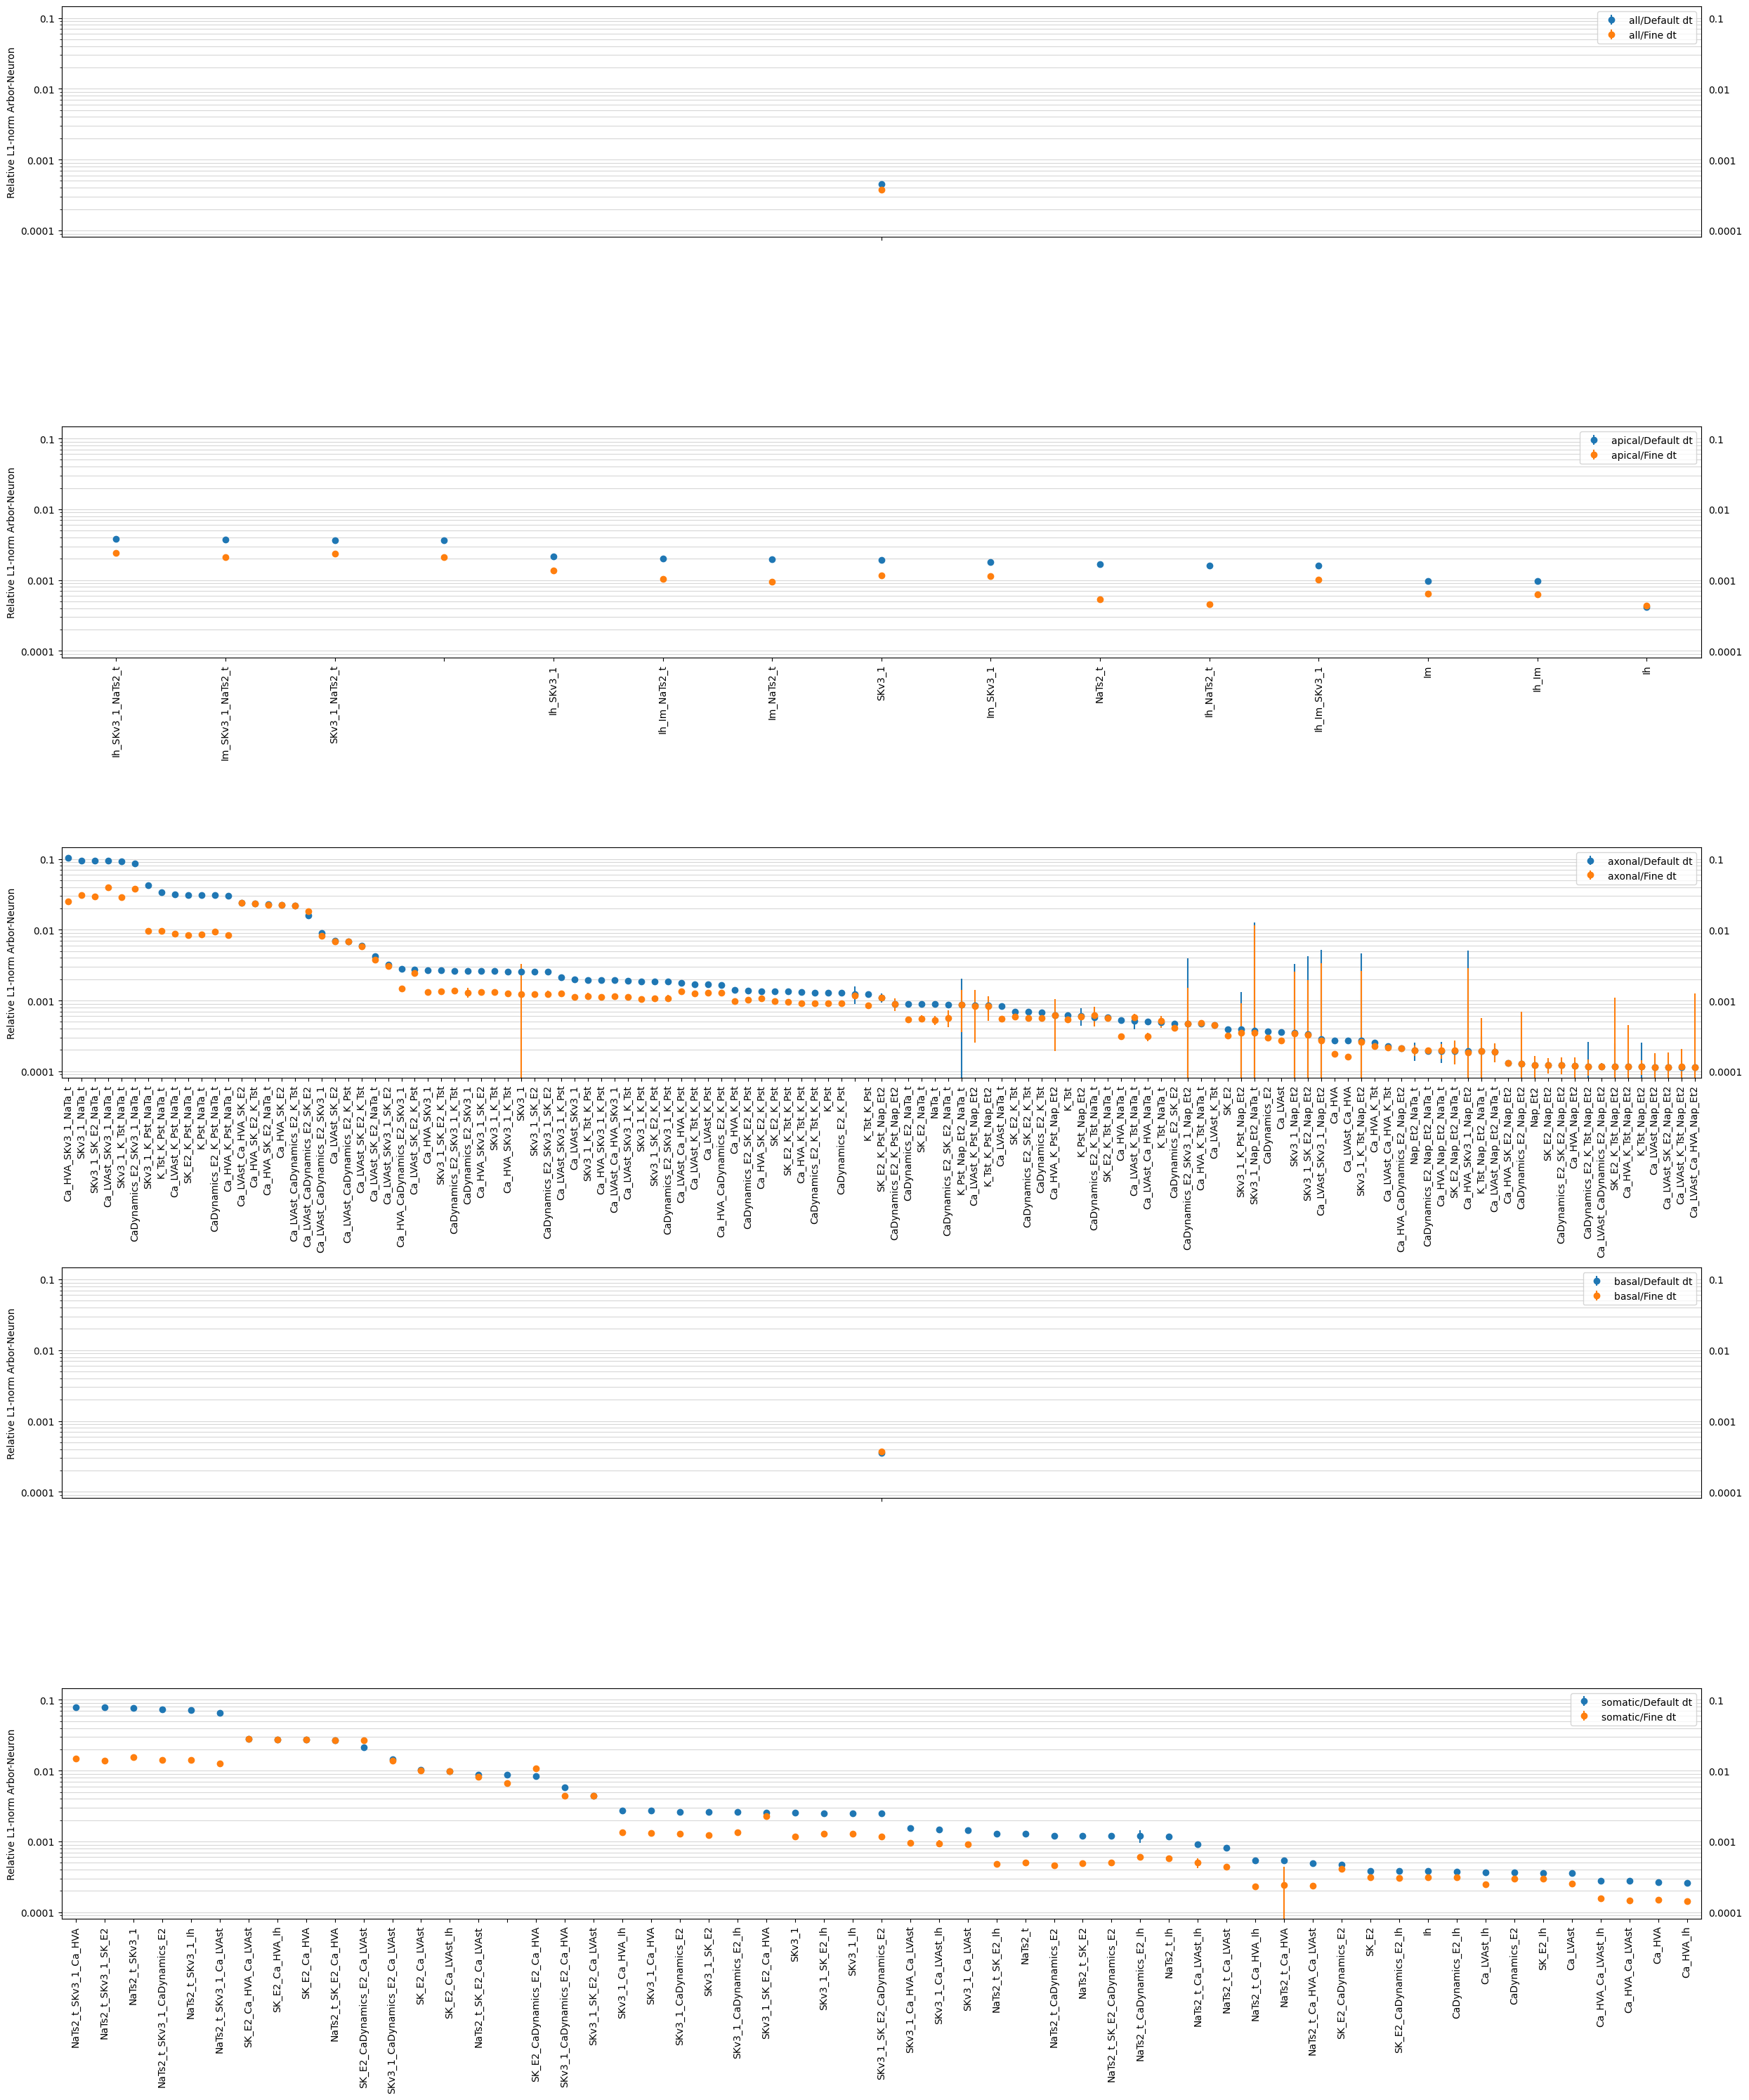

In [8]:
fig, axs = plt.subplots(len(regional_test_status), 1, sharey=True, figsize=(25, 6*len(regional_test_status)))

def show_test_status(ax, region, test_status_df, extra_label=''):
    for dt_setting, dt_group in test_status_df.groupby('dt_setting'):
        ax.errorbar(dt_group['mechs_str'],
                    dt_group['l1_norm'], yerr=dt_group['l1_error'], fmt='o', label= region + '/' + dt_setting + ' dt' + extra_label)
    ax.tick_params(axis='x', labelrotation=90)
    ax.tick_params(labelright=True)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2g"))
    ax.grid(visible=True, which='both', axis='y', alpha=0.5)
    ax.set_ylabel('Relative L1-norm Arbor-Neuron')
    ax.set_xlim(-0.5,len(dt_group)-0.5)
    ax.legend()
    

for i, (region, regional_test_status_df) in enumerate(regional_test_status.items()):
    show_test_status(axs[i], region, regional_test_status_df)
fig.tight_layout()
plt.show()

Repeating these plots on `axonal` and `somatic` regions for only the combinations with the highest-ranked mechanisms helps to get a better overview.

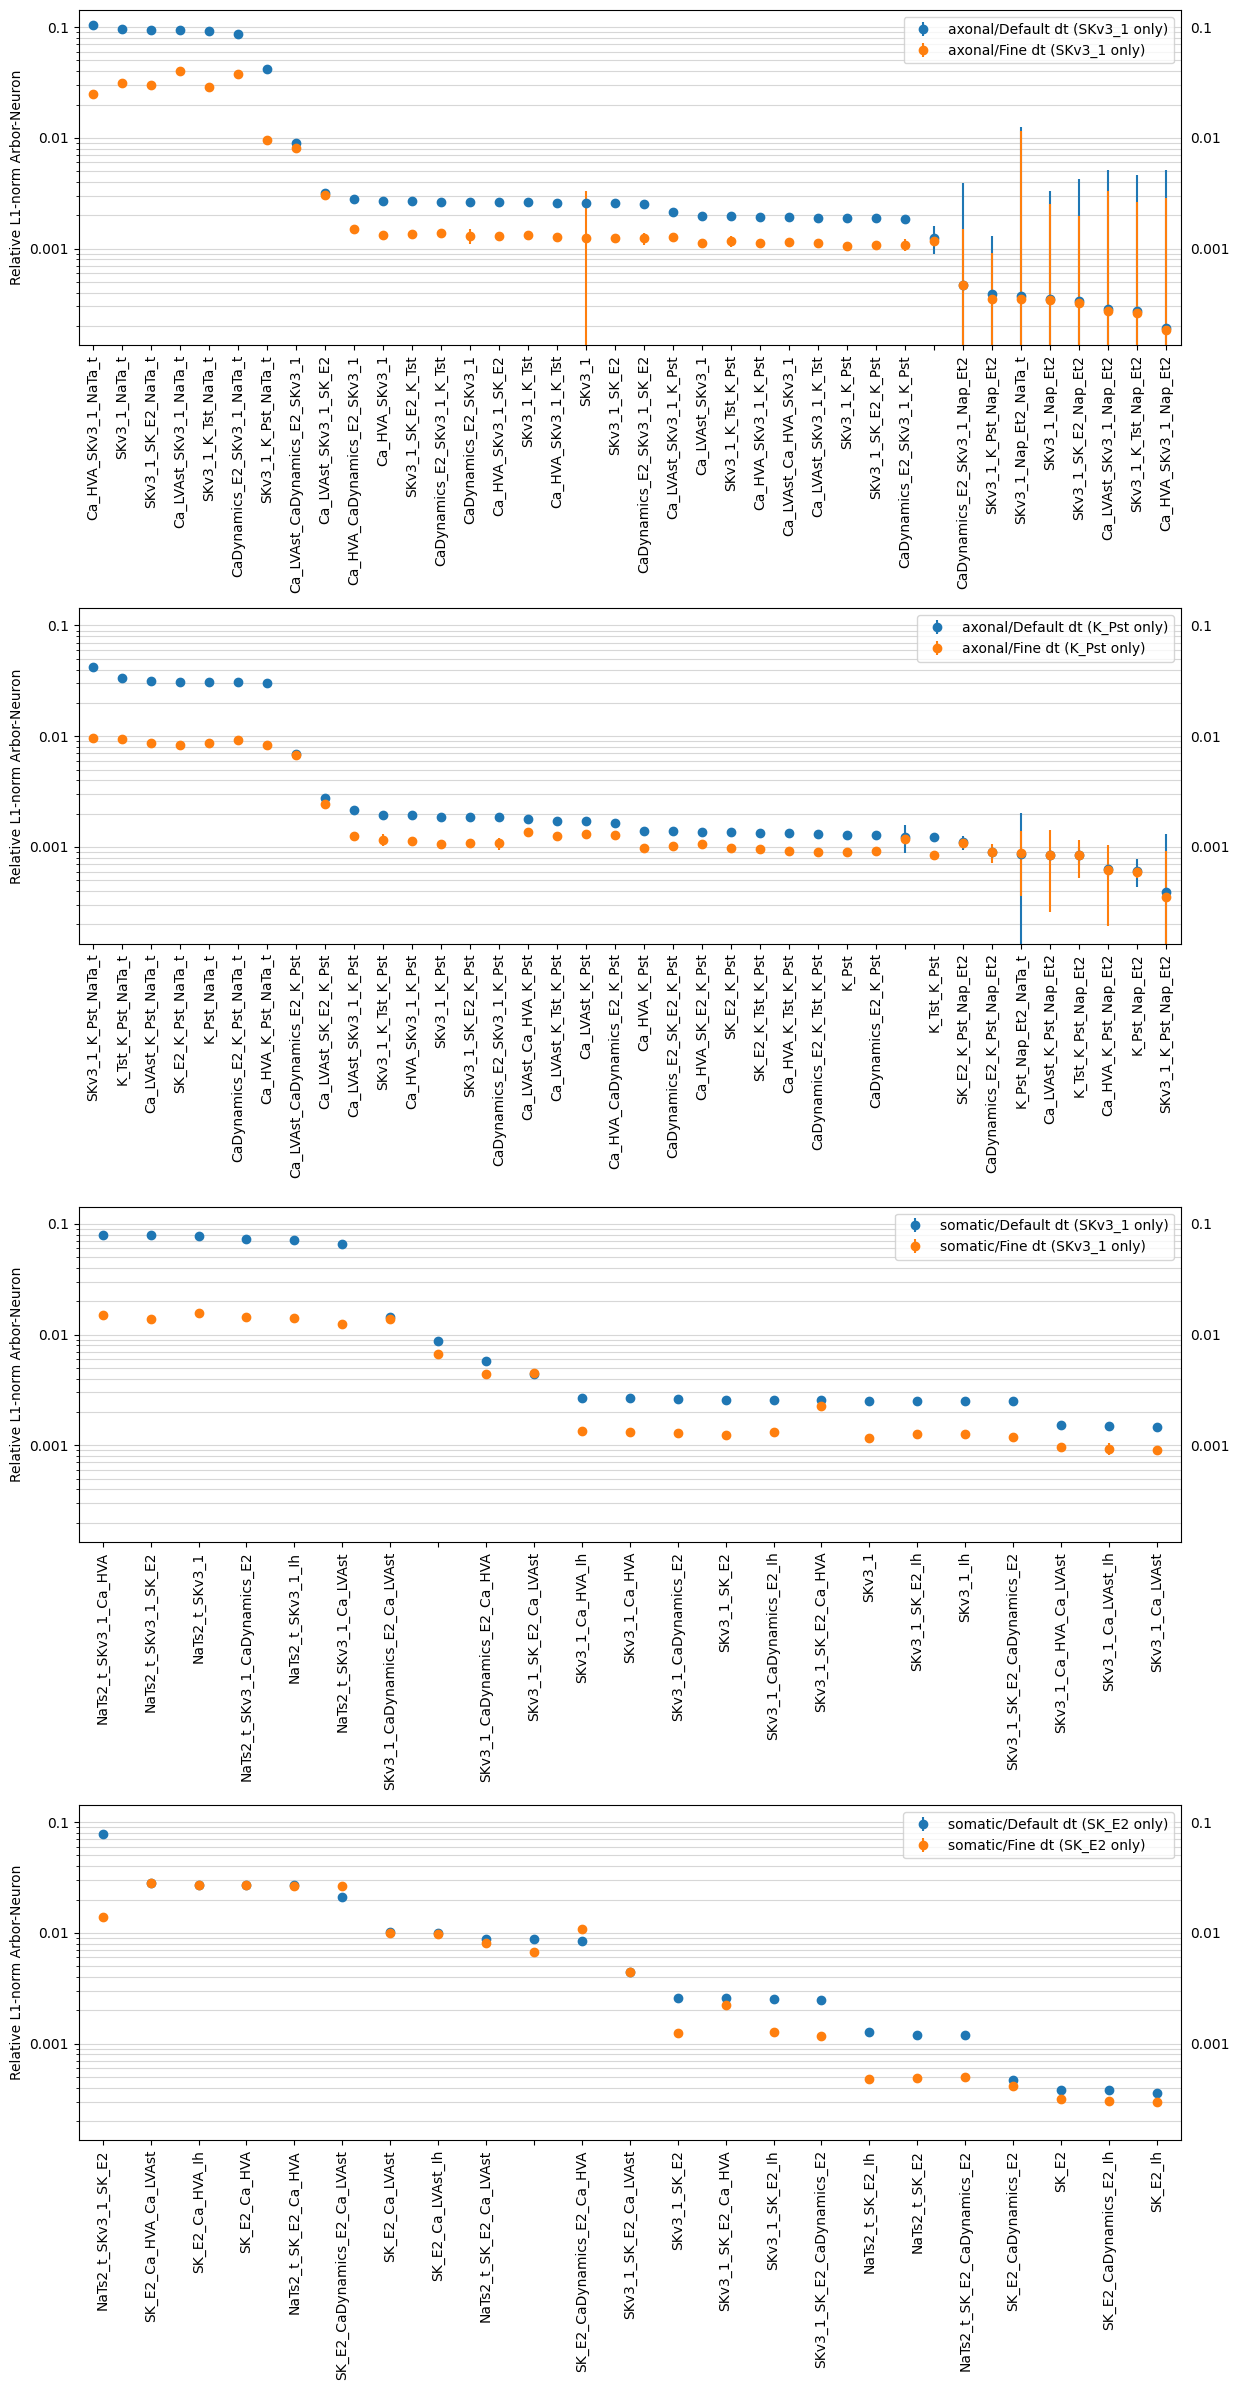

In [9]:
fig, axs = plt.subplots(4, 1, sharey=True, figsize=(12.5, 6*4))

mech_rank_stats['axonal']['Fine']['mech'].head(2)
mech_rank_stats['somatic']['Fine']['mech'].head(2)

i = 0
for region in ['axonal', 'somatic']:
    for mech in mech_rank_stats[region]['Fine']['mech'].head(2):
        show_test_status(axs[i],
                         region,
                         regional_test_status[region][regional_test_status[region]['mechs'].apply(lambda mechs: mech in mechs[region])],
                         ' (' + mech + ' only)')
        i += 1
        
fig.tight_layout()
plt.show()

Tests with N/A result obtained above:

In [10]:
%%bash

cat tests_na

l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2_K_Tst.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2_NaTa_t.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2_SK_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_CaDynamics_E2_NaTa_t.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_Ca_HVA_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA_Ca_LVAst.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA_Ih.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_LVAst_Ih.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_LVAst.ipynb
l5pc_validate_neuron_arbor_somatic_NaTs2_t_CaDynamics_E2_Ca_HVA.ipynb
l5pc_validate_neuron_arbor_somatic_NaTs2_t_CaDynamics_E2_Ca_LVAst.ipynb


Usually this is due to failing to advance time-integration in NEURON. Printing all other cases here.

In [11]:
%%bash

for f in $(cat tests_na); do
    if ! grep NEURON:\ variable\ step\ integrator\ error $f > /dev/null; then
         echo $f
    fi
done

The error messages contain more info.

In [12]:
%%bash

grep -C 1 CVode $(cat tests_na)

l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     "text": [
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb:      "CVode 0x204dded0 simple_cell[0].soma[0] advance_tn failed, err=-7.\n"
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     ]
--
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     "text": [
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb:      "CVode-- At t = 59.0538 and h = 2.94441e-08, the corrector\n",
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-      "convergence failed repeatedly or with |h| = hmin.\n",
--
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     "text": [
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb:      "CVode 0x204dded0 simple_cell[0].soma[0] advance_tn failed, err=-7.\n"
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     ]
--
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     "text": [
l5pc_validate_neuron_ar